In [21]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.relative_locator import locate_with
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager

import chromedriver_binary
import csv

def open_browser():
    """
    Opens a new automated browser window with all tell-tales of automated browser disabled
    """
    options = webdriver.ChromeOptions()
    options.add_argument("start-maximized")

    # remove all signs of this being an automated browser
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)

    # open the browser with the new options
    driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager().install()))
    return driver

def find_jobs(driver):
    """
    Finds all jobs loaded in the browser
    """
    jobs = driver.find_elements(By.CSS_SELECTOR, 'div.row.job-item.ng-star-inserted')
    return jobs

def load_more_job(driver):
    """
    View more job available
    """
    
    # rather than trying to click a button that might have not loaded yet, we will 
    # wait up to 20 seconds for it to actually appear first
    wait = WebDriverWait(driver, timeout = 20)
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "button.btn.btn-outline-dark.btn-lg.px-5.mx-auto.ng-star-inserted")))
   
    more_button = driver.find_element(By.CSS_SELECTOR, "button.btn.btn-outline-dark.btn-lg.px-5.mx-auto.ng-star-inserted")
    if more_button:
        more_button.click()
        
def get_brief_description(job):
    """
    Extracts the job description
    """
    description = {}
    try:
        description['title'] = job.find_element(By.CSS_SELECTOR, 'div.col-12.col-lg h5').text
        description['profile description'] = job.find_element(By.CSS_SELECTOR, 'p.text-truncate.job-profile-description').text
        description['time'] = job.find_element(By.CSS_SELECTOR, 'p.text-muted').text
        description['loc'] = job.find_element(By.CSS_SELECTOR, 'p.text-muted.font-weight-bold').text
        description['total_salary'] = job.find_element(By.CSS_SELECTOR, 'div.text-primary.ng-star-inserted h5').text
        description['per_hour_salary'] = job.find_element(By.CSS_SELECTOR, 'div.text-primary.ng-star-inserted span').text
    except:
        # if the description is missing, just get any text from the job
        description = job.text
    return description

def get_job_info(job, driver):
    """
    Extracts the job information
    """
    description = {}
    description['id'] = i
    try:
        description['Job role'] = driver.find_element(By.CSS_SELECTOR, 'div.pl-md-4.text-left h5').text
        detail = driver.find_elements(By.CSS_SELECTOR, 'div.pl-md-4.text-left p')
        detail_list = [d.text for d in detail]
        
        name = driver.find_elements(By.CSS_SELECTOR, 'div.my-4.ng-star-inserted h6')
        name_lst = [n.text for n in name]
        c = 0
        if "Experience level" in name_lst:
            description['Experience Level'] = detail_list[0].strip()
            description['Experience detail'] = detail_list[1]
            c += 2
        else:
            description['Experience Level'] = None
            description['Experience detail'] = None
        
        if "Job description" in name_lst:
            description['Job description'] = detail_list[c]
            c += 1
        else:
            description['Job description'] = None
        
        if 'Industry' in name_lst:
            description['Industry'] = detail_list[c]
            c +=1
        else:
            description['Industry'] = None
            
        loc = detail_list[c].strip()
        post_code = loc[-4:]
        description['City'] = loc.strip(post_code).strip()
        description['Post code'] = post_code
       
        pay_total = driver.find_element(By.CSS_SELECTOR, 'div.text-primary.ng-star-inserted h5').text.replace('’','').strip("CHF")
   
        description['Pay total'] = float(pay_total)
        pay_per_hour = driver.find_element(By.CSS_SELECTOR, 'div.text-primary.ng-star-inserted span').text.strip("CHF/h")
        description['Pay per hour'] = float(pay_per_hour)
        start_shift = driver.find_element(By.CSS_SELECTOR, 'div.my-4 p').text
        description['Start date'] = start_shift.split(" · ")[0]
        description['Shift'] = int(start_shift.split(" · ")[1].strip(' shifts'))
        
        row = description.values()
        
    except:
        description = None
        row = None
        
    return description, row

def write_to_csv(data):
    header =['Rank','Job role', 'Experience Level','Experience detail', 'Job description','Industry','City','Post Code', 'Pay total', 'Pay per hour', 'Start date','Shift']
    with open('../data/coople_11072023.csv', 'w',encoding='utf-8-sig') as f:
        # create the csv writer
        writer = csv.writer(f)

        # write a row to the csv file
        writer.writerow(header)
        writer.writerows(data)
    

In [22]:
import time
driver = open_browser()
driver.get('https://www.coople.com/ch/jobs/en/')


In [23]:
# Load all jobs
while True:
    try:
        load_more_job(driver)
    except:
        break

In [24]:
jobs = find_jobs(driver)
main_window_handle = driver.current_window_handle
# Iterate through each job listing and open it in a new tab
i = 1
data =[]
for job in jobs:
    job_link = job.find_element(By.TAG_NAME,"a")
    url = job_link.get_attribute("href")
    
    # Open the link in a new tab 
    driver.execute_script("window.open('');")
  
    # Switch to the new window and open new URL
    driver.switch_to.window(driver.window_handles[1])
    driver.get(url)
    
    # Extract information from the new tab
    description, row = get_job_info(job, driver)
    if row:
        data.append(row)
    write_to_csv(data)
    print(description)
    
    # Close the current tab and switch back to the main tab
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
    i += 1
    
# Close the browser
driver.quit()


{'id': 1, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\n- Auffülltätigkeiten (Non Food Bereich)\n- Anfallende Reinigungsarbeiten\n- Mithilfe im Verkauf\n- Kundenberatung\n\nAnforderungen\n- Robust (körperlich fit ohne Einschränkungen)\n- Konversationssichere Deutschkenntnisse\n- Verkaufserfahrungen/Detailhandel (Non Food Bereich) von Vorteil\n- Zuverlässigkeit ist für Sie eine Selbstverständlichkeit\n- Flexibel\n\nWichtig:\n- Es kann auch vorkommen das man bis zu 41 h pro Woche arbeiten muss\n- Einsatzzeiten sind fiktiv und werden vor Ort definiert\n- ------ >> Einsatzzeiten sind zwischen 07:00 - 20:00 Uhr! << -------------\n (bei Ihrer Bewerbung gehen wir davon aus, das Sie bei Bedarf auch um 06.30 Uhr starten können)\n- Sie sind auch samstags verfügbar (

{'id': 8, 'Job role': 'Logistiker/in', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV aufgeführt sein. Personen mit einer abgeschlossenen Berufsausbildung im Logistikbereich müssen sich im entsprechenden Jobprofil registrieren.', 'Job description': '!ACHTUNG: Die angegebenen Schichten sind fiktiv und weichen vom echten Dienstplan ab!\nBei Fragen zu diesem Job bitte Coople und nicht direkt kontaktieren!\n\nDie Schichten können zwischen 05.00 - 00.00 Uhr stattfinden \n(100% Pensum)\n\nLogistiker EFZ/EBA\nSehr gute SAP Kenntnisse\nDeutsch B1\nGegengewichtsstapler (inkl. Schubmaststapler) Fahrausweis\n\n\nFunktionsumschreibung\nStellt als Mitarbeiter/in die Lagerbewirtschaftung mittels Gegengewichtstapler und\nSchubmaststapler sicher und führt Tätigkeiten in Kommissionierung, Verpackung, Transport\nsowie Verbuchung im System aus.\n\nAufgabenschwerpunkte : \nLagerbewirtsch

{'id': 17, 'Job role': 'Logistiker/in', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV aufgeführt sein. Personen mit einer abgeschlossenen Berufsausbildung im Logistikbereich müssen sich im entsprechenden Jobprofil registrieren.', 'Job description': 'Das Team muss an diesen Tagen Unterstüztung von einer tatkräftigen Person haben, Ware verteilen, Leergut einsammeln. Entsorgungen', 'Industry': 'Promotion / Event', 'City': 'Kloten', 'Post code': '8058', 'Pay total': 1586.67, 'Pay per hour': 28.0, 'Start date': '8 Nov 2023', 'Shift': 10}
{'id': 18, 'Job role': 'Logistiker/in', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Logistiker/in, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der a

None
{'id': 27, 'Job role': 'Logistiker/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Personen mit Bereitschaft zu körperlicher Arbeit (z.B. Be-/Entladen von Lastwagen, Einpacken und Rüsten von Sendungen). Handwerkliches Geschick von Vorteil.', 'Job description': 'Als Logistikmitarbeiter für die Verpackung der Ware übernimmst du folgende Aufgaben:\n\nAuftrag:\n- Verpackung aller -Kundenaufträge gemäss Vorgaben\n- Kommissionierung von Kundenaufträgen mit mobilen Handscanner\n\nJe nach Bedarf kannst du auch in anderen Bereichen eingesetzt werden:\nWareneingang -> Entgegennahme der Ware, Kontrolle\nPicken -> Kommissionieren der Ware (verschiedene Positionen & Arten)\nPacken -> Verpacken der Ware\nVerarbeitung -> Kleidung auf Bügel ziehen, Etiketten und Sicherungen anbringen\nWarenausgang -> Stapeln/Einladen der Gebinde\n\nMindestpensum 60%, mit Option auf höheres Pensum\n\nAnforderungen:\nGute Deutschkenntnisse\nZuverlässig, speditiv und genau\nHohes Mass an Flexibilität\nBe

None
None
{'id': 37, 'Job role': 'Assistent/in Gesundheit und Soziales EBA', 'Experience Level': 'Gelernt', 'Experience detail': 'Die EBA-Ausbildung ist eine berufliche Grundbildung, welche 2 Jahre dauert und sowohl theoretische, als auch praktische Elemente beinhaltet. Das Berufsattest EBA muss auf dem Coople-Account hinterlegt sein.', 'Job description': '• Unterstützen der Pflegefachperson bei der Pflege Betreuung der Bewohnerinnen\n• Unterstützen der Bewohnerinnen bei Aktivitäten des täglichen Lebens wie: Waschen Ankleiden, Bewegen, Essen Trinken, Kommunizieren, \n• Auf Delegation, Verrichtungen der anfallenden Pflege- Hausarbeiten wie: Essen servieren, Küche in Ordnung halten, Tee Kaffee zubereiten, Räumlichkeiten in Ordnung halten, Reinigen von Zimmern Mobiliar Arbeiten gemäss Ämtliplan.\n• Delegierte Massnahmen in den Bereichen Pflege, Therapie Rehabilitation durchführen', 'Industry': 'Gesundheitswesen', 'City': 'Biberist', 'Post code': '4562', 'Pay total': 402.5, 'Pay per hour':

{'id': 46, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Berufslehre im Detailhandelsbereich müssen sich mit Ausbildungsniveau "gelernt" registrieren.', 'Job description': 'Aufgaben:\nKontrolle der Wareneingängen, Produkten und Daten\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nKunden und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nDie Einsatztage- und Zeiten sind noch nicht definiert und werden werden vom Auftraggeber laufend ca. 1-3 Wochen

{'id': 53, 'Job role': 'KV - Personalwesen', 'Experience Level': 'Kaufmann/frau EFZ mit >20 Monaten Erfahrung  im Bereich Human Resources', 'Experience detail': 'Der EFZ-Fähigkeitsausweis muss auf dem Coople-Account hinterlegt werden und der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein.', 'Job description': 'Im Auftrag unseres Kunden suchen wir einen Talent Acquisition & Branding Specialist (m/w/d) in der Luftfahrtindustrie.\n\nPensum: 80 - 100%\nZeitraum: Beginn ab sofort - für 6-9 Monate\n\nDeine Tätigkeiten\n• 360° Recruiting Partner für drei Standorte in der Schweiz\no Screening, Active Sourcing, Interviewing\no Coordination & Scheduling\no Offer Management & Negotiation\no Talent Operations im Sinne von Aufbau eines Talentpools\no Stakeholder Management\n• Weiterentwicklung der Rekrutierungsprozesse sowie Erweiterung der Präsenz auf Social Media \n• Aufbau & Zusammenarbeit mit Hochschulen \n• Sicherstellung einer einheitlichen 

{'id': 58, 'Job role': 'KV - Allgemeine Richtungen', 'Experience Level': 'Ausbildung im KV-Bereich >3 Monate', 'Experience detail': 'Personen mit einer kaufmännischen Ausbildung oder Kursausbildung, welche mindestens 3 Monate gedauert hat.', 'Job description': 'Bist du ein Verkaufstalent? Ist dir wichtig, dass dein/e Kund*in im Schadenfall optimal abgesichert ist? Stellst du dich gerne von Kundenkontakt zu Kundenkontakt neuen Herausforderungen? Dann bist du bei uns genau richtig!\n\nQuereinsteiger*Innen sind auch herzlich Willkommen\n\nDein Beitrag\n• Du bist verantwortlich für das telefonische und digitale Beraten von interessierten, potenziellen Kunden\n• Du offerierst bedürfnisgerecht geeignete und nachhaltige Versicherungslösungen, sowie Dienstleistungen aus unserer \n Produktpalette\n• Der erfolgreiche Verkaufsabschluss, nach individueller Beratung, liegt in deinen Genen\nDeine Fähigkeiten und Talente\n• Du besitzt ein ausgeprägtes Verkaufsflair\n• Freude am Telefonieren, schreibe

{'id': 67, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': None, 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3008', 'Pay total': 480.0, 'Pay per hour': 32.0, 'Start date': '8 Nov 2023', 'Shift': 2}
{'id': 68, 'Job role': 'Pflegefachmann/frau HF dipl. (angepasste Ausbildungen)', 'Experience Level': 'Gelernt', 'Experience detail': 'Die Ausbildungsnachweise (Zertifikate / Diplome) müssen auf dem Coople-Account hinterlegt sein. Die NAREG-Nr. ist im Lebenslauf zu erwähnen.', 'Job description': 'Die AG ist ein politisch und religiös neutrales Unternehmen der Gruppe, das sich auf die Betreuung, Unterbringung und Integration von Asylsuchenden und Flüchtlinge

{'id': 74, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'sucht dich!\n\nDeine Aufgaben\n• Verantwortlich für die fachgerechte Zubereitung und Präsentation aller Kostformen gemäss Menüplan und Spezialwünschen\n• Mitverantwortlich für eine effiziente Lagerbewirtschaftung\n• Einhalten des HACCP–Konzeptes und Arbeitssicherheitsrichtlinien\n• Sach- und fachgerechte Organisation der Arbeit innerhalb des Küchendienstes\n• Mitverantwortung für Controlling-Management sowie Qualitätsmanagement\n\nDein Profil\n• Ausbildung zur/zum Köchin/Koch EFZ mit Berufserfahrung\n• Professionelle Arbeitshaltung\n• Selbständige Arbeitsweise\n• Flair für das Anrichten und Dekorieren von Speise

{'id': 83, 'Job role': 'Küchenchef/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Kitchen', 'Industry': 'Gastronomie / Hotel', 'City': 'Kloten', 'Post code': '8302', 'Pay total': 336.0, 'Pay per hour': 42.0, 'Start date': '8 Nov 2023', 'Shift': 1}
{'id': 84, 'Job role': 'Housekeeping', 'Experience Level': 'Ungelernt', 'Experience detail': 'Zimmermädchen/Zimmerbursche mit mindestens einem Jahr Erfahrung in einem Hotelbetrieb (Zimmerdienst / Housekeeping).', 'Job description': 'Reinigung An- & Abreisezimmer, Kontrolle Bleibezimmer', 'Industry': 'Gastronomie / Hotel', 'City': 'Interlaken', 'Post code': '3800', 'Pay total': 337.5, 'Pay per hour': 27.0, 'Start date': '8 Nov 2023', 'Shift': 2}
{'id': 85, 'Job role': 'KV - Immobilien', 'Experience Level': 'Angelernt (ungelernt mit >20 Monate Erfahrung)', 'Experience detail': 'Der Nachweis über >20 Monate Erfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Beruf

{'id': 93, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': "Êtes-vous à la recherche d'une opportunité séduisante dans le domaine culinaire? Alors rejoignez l'équipe de SA, un restaurant et bar à café situé dans le centre commercial Migros à la Tour-de-Trême sous l'enseigne Code-Bar. Nous recherchons, pour compléter notre équipe, un cuisinier ou une cuisinière sachant travailler seul.\n\nDans cette fonction, vous serez responsable de la gestion opérationnelle de la cuisine, de la gestion des stocks et du respect des procédures HACCP. En collaboration avec la responsable de notre point de vente, vous participerez à l'élaboration des menus et de l'offre pour nos clients. V

{'id': 100, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': "Les horaires sont fictifs, ceux-ci indiquent la date de la prise de contact, la mission proprement dite est convenue sur rendez-vous, en fonction des disponibilités.\n_________________________________________________________________________________________________________________________________________________\n\nVous faites changer les roues de votre voiture (y compris l'équilibrage) pour des pneus/pneus d'hiver.\nCe faisant, vous évaluez l'amabilité, le comportement en matière de service et la proximité avec le client depuis la prise de rendez-vous jusqu'au changement de pneus et à la prise de congé.\n\nVos dépenses (frais de changement de roue) vous seront remboursées jusqu'à un montant maximum de 120 CHF.\nLe paiement ne s'effectue que sur présentation d'une quittance valable !\n\nLes dates clés :\nPour le test, vous recevez des honoraires de 20 CHF. \nEn pl

None
{'id': 111, 'Job role': 'Personenwagenfahrer/in (bis 3.5T)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Aufgaben:\n- Rechtzeitige und korrekte Beladung des 3,5-Tonnen-Lieferfahrzeugs gem. Ladeliste (Allgemeine Ware, Nonfood-, Frisch- und Tiefkühlprodukte)\n- Gewährleistung qualitativer Aspekte (Hygiene, Kühlkette)\n- Pünktliche und korrekte Auslieferung des Kundenaufträge mit dem Lieferfahrzeug\n- Abwicklung des gesamten Zahlungsverkehrs beim Kunden (Barzahlung, Debit- und Kreditkartenbelastungen, Verrechnung der Nachbelastungen und Gutschriften)\n- Abwicklung der Retouren und Entgegennahme des Leerguts\n- Abrechnung der Touren in der Drehscheibe und Bedienung des Cash-Centers\n- Fahrzeugunterhalt (Pflege, Reinigung und Betankung des Fahrzeuges)\n- Sicherstellung einer ökonomischen Fahrweise und sorgsamer Umgang mit den Betriebsmitteln (Lieferfahrzeug, Zahlungsgerät, Mobiltelefon etc.)\n-Hauptsächlich Nachmittags-Schichten (Mo-Sa 12Uhr bis 21Uhr)\n\nA

{'id': 124, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': None, 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4058', 'Pay total': 280.0, 'Pay per hour': 35.0, 'Start date': '8 Nov 2023', 'Shift': 1}
None
{'id': 126, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Du bist eine aufgestellte und herzliche Persönli

None
{'id': 136, 'Job role': 'Spülküchen-Mitarbeiter/in mit Erfahrung', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Produktion , Menü Service , gerne Leute die alle 3 Tage können.', 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4058', 'Pay total': 75.0, 'Pay per hour': 25.0, 'Start date': '8 Nov 2023', 'Shift': 1}
{'id': 137, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'Ob Student oder flexibles Mami samt Service-Erfahrung - Lust, in einem atemberaubenden Ambiente an vorderster Front mitzuwirken? Ergänze unser Team als motivierte, aufgestellte und belastbare Mitarbeitende,. Auf dich wartet ein cooles Team und spanne

None
{'id': 145, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Fertigung von kalten und warmen Speisen\nErstellung der täglichen Mise en Place\nRegenerieren der Speisen\nErledigung von diversen Aufräum- sowie Reinigungsarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8004', 'Pay total': 577.5, 'Pay per hour': 35.0, 'Start date': '9 Nov 2023', 'Shift': 2}
{'id': 146, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) u

None
{'id': 155, 'Job role': 'Handwerk & Auf-/Abbau', 'Experience Level': 'Ungelernt', 'Experience detail': 'Personen mit Bereitschaft zu körperlicher Arbeit. Handwerkliches Geschick von Vorteil. Die Aufgaben können von einfachen Handlangertätigkeiten (z.B. Mobiliaraufbau), bis zu handwerklichen Tätigkeiten reichen.', 'Job description': 'Wir suchen erfahrene Handwerker und Auf- und Abbau-Mitarbeiter, die sich mit dem Aufbau von Ausstellungen auskennen. Als Teil unseres Teams bei hast du die Möglichkeit, bei der Gestaltung und dem Aufbau verschiedener Ausstellungsstände mitzuwirken.\n\nDeine Hauptaufgaben umfassen:\n- Aufbau von Ausstellungen mit einem Standbausystem aus Holz, Tischen und Wänden\n- Verwendung von Akkuschraubmaschinen und anderen Werkzeugen, um den Aufbau effizient zu gestalten\n- Sicherstellung, dass alle Elemente sicher und stabil montiert werden\n- Umgang mit anderen Teammitgliedern und Koordination der Aufgaben vor Ort\n\nWir suchen nach Bewerbern, die Erfahrung im A

{'id': 163, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Sie sind gelernte Köchin oder gelernter Koch EFZ und unterstützen unseren Küchenchef und unser Küchenteam in sämtlichen Schichtdiensten.\n\nIhr Profil: Erfahrung im Heim- und Gemeinschaftsgastronomie, Freundlichkeit und Aufgeschlossenheit.\n\nIhre Aufgabe: AVOR und Kochen der Malzeiten für unsere Bewohnerinnen und Bewohner sowie für unsere Mitarbeitenden; Mise en Place nach Vorgaben Küchenchef.', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8004', 'Pay total': 7490.0, 'Pay per hour': 35.0, 'Start date': '9 Nov 2023', 'Shift': 25}
{'id': 164, 'Job role': 'Spülküchen-Mitarbeiter/in mit Erfah

None
{'id': 177, 'Job role': 'Reinigungsmitarbeiter/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Arbeitskraft für Reinigungsarbeiten (z.B. Office, Raumpflege etc.).', 'Job description': 'Unterstützung Office Service', 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3073', 'Pay total': 87.75, 'Pay per hour': 27.0, 'Start date': '9 Nov 2023', 'Shift': 1}
None
{'id': 179, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Wir suchen dich!\n\nZu deinen Aufgaben gehören:\n- Anrichten der Teller im Mittagsservice\n- Mithilfe in der Spülküche\n- Allgemeine Aufräum- und Reinigungsarbeiten\n\nAnforderungen:\n- Gute Deutschkenntnisse\n- Freude am Gästekontakt\n-Zuverlässige und selbstständige Arbeitsweise\n\nEinsatzzeit kann variieren -/+ 1 Stunde\n\nWir freuen uns auf deine Bewerbung!', 'Industry': 'G

{'id': 191, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Apero, Live-Cooking Station, Dessert', 'Industry': 'Gastronomie / Hotel', 'City': 'Spreitenbach', 'Post code': '8957', 'Pay total': 297.0, 'Pay per hour': 33.0, 'Start date': '9 Nov 2023', 'Shift': 2}
{'id': 192, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Mitarbeit im Getränke-Service, Aperobedienung', 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3007', 'Pay total': 52.0, 'Pay per hour': 26.0, 'Start date': '9 Nov 2023', 

{'id': 204, 'Job role': 'Spülküchen-Mitarbeiter/in mit Erfahrung', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Sie suchen nach einer spannenden Gelegenheit, in einem angesehenen als Spüler/in zu arbeiten? Dann sind Sie bei uns genau richtig! \nBei AG - bieten wir eine erstklassige kulinarische Erfahrung für unsere Gäste. Als Spüler/in sind Sie verantwortlich für das Reinigen und Sortieren von Geschirr, Besteck und Kochutensilien in unserer Spülküche. \nZu Ihren Aufgaben gehören auch andere allgemeine Tätigkeiten, die in der Küche anfallen. \nWir suchen eine sorgfältige und zuverlässige Person, die gute Kommunikationsfähigkeiten hat und in der Lage ist, sowohl eigenständig als auch im Team zu arbeiten. \nWenn Sie Leidenschaft für die Gastronomie haben und Teil unseres motivierten und freundlichen Teams werden möchten, dann bewerben Sie sich jetzt! \n AG - liegt in Basel und bietet eine angenehme Arbeitsumgebung sowie wettbewerbsfähige Vergütung. \nWir freuen

{'id': 213, 'Job role': 'Personenwagenfahrer/in (bis 3.5T)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'In diesem Einsatz liefern Sie Kundenbestellungen mittels Kleintransporter in einer zugeteilten Region aus. \nZusätzlich erwarten Sie folgenden Aufgaben:\n- Vorbereitung und Bereitstellung von Warenbestellungen\n- Abwicklung von Retouren\n- Abwicklung der Zahlung bei Barzahler\n- Pflege des anvertrauten Fahrzeuges\n- Mithilfe bei allgemeinen Lagerarbeiten\n\nUm diese Aufgaben auszuführen bringen Sie Folgendes mit:\n- Gültiger Führerschein der Kategorie B\n- Freude am Autofahren sowie am Kundenkontakt\n- Sehr gute Deutschkenntnisse\n- Flexibilität und hohe Selbstständigkeit', 'Industry': 'Promotion / Event', 'City': 'Eschenbach', 'Post code': '8732', 'Pay total': 3332.0, 'Pay per hour': 24.5, 'Start date': '10 Nov 2023', 'Shift': 16}
None
{'id': 215, 'Job role': 'Pflegefachmann/frau HF dipl. (angepasste Ausbildungen)', 'Experience Level': 'Gelernt', 'Exper

None
{'id': 223, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Berufslehre im Detailhandelsbereich müssen sich mit Ausbildungsniveau "gelernt" registrieren.', 'Job description': 'Aufgaben:\nAktive Bedienung und Beratung von Kunden im Bereich Funktionsbekleidung und Laufschuhe\nSicherstellung einer sauberen, aufgefüllten und ordentlichen Lager- und/oder Verkaufsfläche \nAuffüllen von Ware auf der Verkaufsfläche\n\nProfil:\nBegeisterung für den Kontakt mit Kunden und Bereitschaft, eine ausgezeichnete Dienstleistung anzubieten (Gastgeberrolle)\nEine Leidenschaft für die unterschiedlichsten Sportarten und entsprechende Produkte-Kenntnisse\nKommunikative, aufgeschlossene Persönlichkeit\nZuverlässig, verantwortungsbewusst und teamfähig\nHohe Agilität\nGute Deutschkennt

{'id': 232, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'Möchten Sie Teil eines dynamischen Teams in einem beliebten - in Zürich sein? Wir suchen eine flexible Servicehilfe für den Mittagsservice im .\n\n- Unterstützung des Mittagsservices für ca. 2 Stunden\n- Ausgabe und Servieren von Getränken und Mittagsmenü am Buffet\n- Keine Kassen- und Geldtransaktionen\n\nAls Teil unseres erfolgreichen Teams bieten wir Ihnen die Möglichkeit, in einer lebhaften und freundlichen Atmosphäre zu arbeiten. Unser befindet sich in zentraler Lage in Zürich und ist sowohl mit öffentlichen Verkehrsmitteln als auch mit dem Auto gut erreichbar.\n\nWir suchen motivierte, flexible und zuv

None
None
{'id': 240, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Für die SWISS Business Class Lounge im Terminal A am Flughafen suchen wir eine/n engagierte/n Servicefachmitarbeiter/in zur Unterstützung der Buffetpflege sowie Abräumen der Tische.\nZWINGEND AUSWEISDOKUMENT ZUM EINSATZ MITBRINGEN.\n\nBei Anfahrt mit dem Auto kann nach erfolgter Anstellung eine Parkkarte bei Coople (mailto: [link hidden]) beantragt werden. Die aufladbare Parkkarte ist anschliessend nach 2 Arbeitstagen (Mo-Fr) auf dem Ausweisbüro des Flughafen Zürichs abholbereit.\n\n\nUniform:\nSchwarze klassische Arbeitsschuhe, Schwarzes langärmeliges Shirt ( ohne aufdrucke )und schwarze Bundfaltenhosen durch den Arbeitnehmer mitzubringen.\nKeine sichtbaren Tattoos und Piercing', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8060'

None
{'id': 255, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'für ein Dinner im DAS ZELT in Solothurn suchen wir dich zur Mithilfe im Service für Mise en Place Arbeiten, Essen- und Getränkeservice, Tische Abräumen und diverse Reinigungsarbeiten.', 'Industry': 'Gastronomie / Hotel', 'City': 'Solothurn', 'Post code': '4500', 'Pay total': 420.0, 'Pay per hour': 30.0, 'Start date': '10 Nov 2023', 'Shift': 4}
{'id': 256, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Zur Unterstützung unseres Service-Te

None
{'id': 276, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': '- Produktion der Speisen \n- Ausgabe der Speisen zu den Servicezeiten\n- Mithilfe in anderen Bereichen falls notwendig\n- Mitverantwortlich für Ordnung und Sauberkeit\n- Diverse Mise en Place arbeiten\n- Gästebetreuung \n\nWichtige Informationen:\nDeutsch sprechen, Schweizerdeutsch verstehen.\nEs gibt ein Spesenabzug für die Verpflegung.\nCHF 2.00 für das Garderoben Kästli mitnehmen\nEinsatz kann etwas kürzer oder länger dauern, bitte nötige Flexibilität mitbringen.\nPasswort für die Gurtenbahn an der Kasse mitteilen , damit Ihr gratis fahren könnt: Coople\nDie Gurtenbahn fährt alle 15 Minuten. Es gibt kei

{'id': 287, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen eine kommunikative Persönlichkeit, die unsere Kundenbar i der Boutique bewirtschaftet und unseren Gästen Getränke ausgiebt!', 'Industry': 'Promotion / Event', 'City': 'Suhr', 'Post code': '5034', 'Pay total': 175.5, 'Pay per hour': 27.0, 'Start date': '11 Nov 2023', 'Shift': 1}
{'id': 288, 'Job role': 'Rezeptionsmitarbeiter/in / Concierge', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Hotelrezeptionsdienst\nGute Kenntnisse von Protel erforderlich.', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8002', 'Pay total': 2754.0, 'Pay per hour': 36.0, 'Start date': '11 Nov 2023', 'Shift': 9}
{'id': 289, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nSicherstellen der Verkaufs

{'id': 301, 'Job role': 'Reinigungsmitarbeiter/in', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV aufgeführt sein. Personen mit einer abgeschlossenen Berufsausbildung im Reinigungsbereich müssen sich im entsprechenden Jobprofil registrieren.', 'Job description': 'Reinigen der benutzen Tische im Schwimmbad\nAbwaschen und Wegräumen des benutzen Geschirrs unserer Gäste (Spülmaschine)\nHilfe an der Kasse beim Tippen der Konsumationen (kein Geldfluss)\nAuffüllen von Getränken und Speisen in den Verkaufsautomaten- & Vitrinen\nBedienen von unseren Gästen und der Kasse\nZubereiten von kleinen Snacks\nAuffüllen des Selbstwahlbuffets und der Automaten\nPflege des Bestellwesens\nLagerbewirtschaftung\nAusführen von allgemeinen Reinigungsaufgaben\n\nHinweis:\nDas befindet sich im Bad. Es ist dadurch warm, laut und eine hohe Luftfeuchtigkeit ist gegeben.\n\nBei hohem Gästeaufkomme

{'id': 312, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Vorbereitungen Apero & Menü, Buffet, Reinigung/Ordnung', 'Industry': 'Gastronomie / Hotel', 'City': 'Solothurn', 'Post code': '4500', 'Pay total': 340.0, 'Pay per hour': 40.0, 'Start date': '11 Nov 2023', 'Shift': 1}
{'id': 313, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Zubereitung von kal

{'id': 323, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Mitarbeit im Getränke-Service, Burger, Menuservice allgemeine Reingungsarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3007', 'Pay total': 189.0, 'Pay per hour': 27.0, 'Start date': '11 Nov 2023', 'Shift': 1}
{'id': 324, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Sind Sie auf der Suche nach einer spannenden und abwechslungsreichen Arbeit im Bereich Gastronomie? Dann haben wir die perfekte Stelle für Sie! Wir suchen derzeit Logen- und Salon Servicemitarbeiter für den -Bereich im Fußballstadion .\n\nAls Servicemitarbeiter im -Bereich sind Sie für die Betreuung unsere

None
{'id': 334, 'Job role': 'Pflegehelfer/in SRK', 'Experience Level': 'mit Zertifikat und >20 Monaten Erfahrung', 'Experience detail': 'Das Zertifikat des Pflegehelferkurses muss auf dem Coople-Account hinterlegt sein. Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit (20 Monate bei 100%-Beschäftigung) muss im CV aufgeführt sein.', 'Job description': '• Pflegen und Betreuen der Bewohnenden unter Berücksichtigung einer personenzentrierten Hal-tung\n• Ausführen von logistischen und administrativen Aufgaben\n• Eingehen auf die Wünsche und Gewohnheiten betagter und pflegebedürftiger Menschen\n• Mitarbeit in der Alltagsgestaltung auf der Abteilung', 'Industry': 'Gesundheitswesen', 'City': 'Wettingen', 'Post code': '5430', 'Pay total': 120.34, 'Pay per hour': 32.09, 'Start date': '11 Nov 2023', 'Shift': 1}
{'id': 335, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fäh

{'id': 347, 'Job role': 'Logistiker/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Personen mit Bereitschaft zu körperlicher Arbeit (z.B. Be-/Entladen von Lastwagen, Einpacken und Rüsten von Sendungen). Handwerkliches Geschick von Vorteil.', 'Job description': 'Wir suchen erfahrenes und freundliches Logistikpersonal für verschiedene Aufbautätigkeiten im \n\nDeine Aufgaben: Einrichten der Eventlocations mit Mobiliar, Bankettbestuhlung und Tische nach Plan aufbauen, verschiedene Logistikerarbeiten im Haus, diverse Anfallande Tätigkeiten\nDeine Schlüsselkompetenzen: Motiviertes Auftreten, Freundlichkeit und Aufgeschlossenheit, starke Kundenorientierung. Pragmatisches Denken, Lösungsorientiertes Arbeiten\n\nWir bitten Sie Verpflegung selbst mitzubringen.\nVerpflegungsmöglichkeit gegen Aufpreis auch vor Ort möglich! (Sandwich, Getränke, Süssigkeiten, etc)', 'Industry': 'Promotion / Event', 'City': 'Thun', 'Post code': '3604', 'Pay total': 90.3, 'Pay per hour': 24.08, 'Start dat

{'id': 358, 'Job role': 'Verträger/in / Verteiler/in (Zeitungen, Flyer, Samples)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'An unseren zukünftigen Mitarbeiter:\n\nDu arbeitest gerne selbständig und suchst eine Nebenbeschäftigung, mit der du in den Tag starten kannst? Dann sind die Einsätze bei als Frühzusteller*in genau das richtige für dich. Die Einsätze erfolgen von Montag bis Samstag zwischen 05.00 Uhr und 06.30 Uhr. Die Einsätze starten im Depot xx und enden mit dem letzten Briefkasten deiner Tour. Die Entschädigung für den jeweiligen Einsatz erfolgt auf einer Routenberechnung, somit handelt es sich um eine fixe Vergütung von CHF xx für diese Route bei einer realistischen und auf Erfahrungswerten basierenden Zeitannahme von xx Minuten. Das Gute daran, du kannst mit deiner Route auch schneller sein und die Entschädigung bleibt unverändert. Für dein eigenes Fahrzeug erhältst du aufgrund der Routenberechnung eine fixe Entschädigung von CHF xx. \n\nWicht

None
{'id': 365, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Sicherheitsschulung Roche muss vor einem Einsatz gemacht werden: [link hidden]\n***********************\n- Vorbereitung und Zubereitung von Speisen im kalten und warmen Küchenbereich nach vorgegebener Rezeptur inkl. Degustation \n- Einhalten von Hygienebestimmungen (TQM)\n - korrekte Auskunft über Angebot/Allergene\n - Verantwortlich für die korrekte und ordentliche Lagerung der Waren in den Kühl, Tiefkühl und Lagerbereichen \n- Tägliches Führen der Inventarlisten und Mitarbeit bei der monatlichen Inventur\n- Bereitschaft zu Sondereinsätzen ausserhalb der normalen Arbeitszeiten\n- Kostenloses Mittagessen\n

{'id': 373, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Berufslehre im Detailhandelsbereich müssen sich mit Ausbildungsniveau "gelernt" registrieren.', 'Job description': '!Die Zeiten im Einsatz sind fiktiv!\n!Den genauen Arbeitsplan erhältst du vor Ort!\n\nDein Aufgabenbereich:\n* Arbeit im Restpostenverkauf (auch möglich in anderen Abteilungen)\n* Kundenbedienung und –beratung\n* Warenpräsentation und Sicherstellung der Verfügbarkeit, Warenbewirtschaftung\n* Qualitätskontrolle und Reinigungsarbeiten\n\nWir erwarten von dir:\n* Teamfähige, selbständige und belastbare Persönlichkeit\n* Gepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\n* Ausgezeichnete Deutschkenntnisse sind zwingende Voraussetzung\n* Gute körperliche Verfassung\

{'id': 380, 'Job role': 'Handwerk & Auf-/Abbau', 'Experience Level': 'Handwerk gelernt', 'Experience detail': 'Schreiner/in, Zimmermann/Zimmerin, Zelt-, Bühnen- und Messebauer/in, etc. mit abgeschlossener handwerklicher Berufslehre.', 'Job description': 'Wir suchen dich als Mitarbeiter bei der . \n\n***DIE SCHICHTEN SIND FIKTIV***\nWir behalten uns vor, Bewerber direkt abzulehnen die gemäss Profilbeschreibung nicht passen.\nBei Fragen, wende dich bitte direkt an coople und nicht an die .\nDie Kommunikation über ausgeschriebene Jobs, geht ausschliesslich über coople.\n\nAnforderungen\nPensum 100%\nDeutsch Nivea B2\n\nFach- und Methodenkompetenz Zwingend Optional\n• Kann Entscheidungen im Rahmen der individuellen Fachkompetenz treffen \n• Wendet Maschinen und Fertigungshilfsmittel selbstständig an gemäss der\n\nAusbildung und Qualifikation.\n• Berufslehre EFZ (4 Jahre) (z.B.: Kältesystemmonteur EFZ, Polymechaniker mit\nHLK-Erfahrung (Heizung, Lüftung, Klima), Automatiker EFZ, Elektrotech

{'id': 390, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': '- Kasse\n- Aufbewahrung\n- Einräumen von Regalen', 'Industry': 'Detailhandel / Logistik', 'City': 'Langendorf', 'Post code': '4513', 'Pay total': 212.5, 'Pay per hour': 25.0, 'Start date': '13 Nov 2023', 'Shift': 1}
{'id': 391, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Sport ist Ihre Leidenschaft?\nUnsere auch!\nDenn alles, was wir tun dreht sich um Sport - wir wollen unseren Usern Sport ermöglichen und sind selbst begeistert dabei. Egal ob in unserer Freizeit, als Leistungs- oder Hobbys

{'id': 408, 'Job role': 'Sozialpädagoge/in HF', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Bitte nur bewerben, wenn Bereitschaft zu mehreren Diensten im November / Dezember vorhanden ist.\n\nSie begleiten 10 Bewohner*innen in Aussenwohngruppen in Horgen in ihrem Lebensalltag. \n\nIhr Gestaltungsraum: \n- Fachliche Begleitung von bereits sehr selbständigen Klient*innen in einem interdisziplinären Team\n-  Einheiten \n- Mitwirken beim Verbessern und Erhalten der Lebensqualität\n- Vielfältiges und abwechslungsreiches Betreuungsangebot\n- Förderung der Selbständigkeit und der Selbstbestimmung\n- Gewährleisten eines kontinuierlichen Informationsflusses und eines reibungslosen Betriebsablaufs\n- Einhalten der Vorschriften zur Hygiene, Betriebssicherheit und zum Gesundheitsschutz\n- Administrative Tätigkeiten\n\nIhr Beitrag:\n- Abgeschlossene Berufsausbildung (HF oder FH), Erfahrung mit Menschen mit kognitiver Beeinträchtigung bzw. psychischer Beeinträchtigung od

None
{'id': 416, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': '- Produktion der Speisen \n- Ausgabe der Speisen zu den Servicezeiten\n- Mithilfe in anderen Bereichen falls notwendig\n- Mitverantwortlich für Ordnung und Sauberkeit\n- Diverse Mise en Place arbeiten\n- Gästebetreuung \n\nWichtige Informationen:\nDeutsch sprechen, Schweizerdeutsch verstehen.\nEs gibt ein Spesenabzug für die Verpflegung.\nCHF 2.00 für das Garderoben Kästli mitnehmen\nEinsatz kann etwas kürzer oder länger dauern, bitte nötige Flexibilität mitbringen.\nPasswort für die Gurtenbahn an der Kasse mitteilen , damit Ihr gratis fahren könnt: Coople\nDie Gurtenbahn fährt alle 15 Minuten. Es gibt kei

{'id': 429, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': "Les horaires sont fictifs, ceux-ci indiquent la date de la prise de contact, la mission proprement dite est convenue sur rendez-vous, en fonction des disponibilités.\n_________________________________________________________________________________________________________________________________________________\n\nVous faites changer les roues de votre voiture (y compris l'équilibrage) pour des pneus/pneus d'hiver.\nCe faisant, vous évaluez l'amabilité, le comportement en matière de service et la proximité avec le client depuis la prise de rendez-vous jusqu'au changement de pneus et à la prise de congé.\n\nVos dépenses (frais de changement de roue) vous seront remboursées jusqu'à un montant maximum de 120 CHF.\nLe paiement ne s'effectue que sur présentation d'une quittance valable !\n\nLes dates clés :\nPour le test, vous recevez des honoraires de 20 CHF. \nEn pl

{'id': 436, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Serviceaushilfe, Allrounder, Runner, Zoom Restaurant, The Circle 1', 'Industry': 'Gastronomie / Hotel', 'City': 'Kloten', 'Post code': '8302', 'Pay total': 630.0, 'Pay per hour': 30.0, 'Start date': '14 Nov 2023', 'Shift': 4}
{'id': 437, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Nous avons besoin de ton aide!\n \nTes missions:\nOpérations de mise en place\nMise en place et rangement \nService Banquet\nTâches de nettoy

{'id': 447, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Mithilfe bei einem Anlass von 20 Personen\nZusätzliche Unterstützung im à la carte Service.\nMise-en-place und Aufräumarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8022', 'Pay total': 150.0, 'Pay per hour': 30.0, 'Start date': '15 Nov 2023', 'Shift': 1}
{'id': 448, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei 

None
{'id': 459, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Steh-Apéro in ungezwungener und einmaliger Atmosphäre im Kino Rex Thun', 'Industry': 'Gastronomie / Hotel', 'City': 'Thun', 'Post code': '3600', 'Pay total': 84.0, 'Pay per hour': 28.0, 'Start date': '15 Nov 2023', 'Shift': 1}
{'id': 460, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Herzlich Willkommen im Zürich. Mitten im trendigen Kreis 4 liegt unser in 2018 renoviertes 4-Sterne . Mit seinen 365 Zimmern ist es auf den Business Gast ausg

{'id': 468, 'Job role': 'Pflegefachmann/frau HF dipl. (angepasste Ausbildungen)', 'Experience Level': 'Gelernt', 'Experience detail': 'Die Ausbildungsnachweise (Zertifikate / Diplome) müssen auf dem Coople-Account hinterlegt sein. Die NAREG-Nr. ist im Lebenslauf zu erwähnen.', 'Job description': 'Die AG ist ein politisch und religiös neutrales Unternehmen der Gruppe, das sich auf die Betreuung, Unterbringung und Integration von Asylsuchenden und Flüchtlingen in der Schweiz spezialisiert hat. Dabei ist sie kompetente Partnerin von Bund, Kantonen und Gemeinden.\n\nFür unsere Kollektivunterkunft am Standort xy suchen wir Pflegefachperson \n\nIhre Herausforderungen\n• Verantwortlich für die medizinische Betreuung der uns anvertrauten Asylsuchenden\n• Triage-Funktion\n• Führen der Hausapotheke\n• Sicherstellung der medizinischen Grundversorgung\n• Kontrollierte Medikamentenabgabe\n• Kontaktperson für Ärzte und Spitäler\n• Begleiten der Arztvisite\n• Medizinische Dokumentation der Krankheits

{'id': 476, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Bankett, aufdecken, abräumen, allg. arbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8036', 'Pay total': 172.08, 'Pay per hour': 35.0, 'Start date': '16 Nov 2023', 'Shift': 1}
{'id': 477, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'WAS: Promotion, Verkauf und Degustation von .\nWO: Prodega, Neuendorf\nWIE: Potenzielle Kundschaft ansprechen, einfache Drinks mixen und erklären.\nVORAUSSETZUNG: Gastro-Erfahrung, Erfahrung im Verkauf, freundlich, kontaktfreudig, weiblich', 'Industry': 'Promotion 

{'id': 489, 'Job role': 'Logistiker/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Personen mit Bereitschaft zu körperlicher Arbeit (z.B. Be-/Entladen von Lastwagen, Einpacken und Rüsten von Sendungen). Handwerkliches Geschick von Vorteil.', 'Job description': 'Unterstützung im Verkauf mit Fokus auf den Kabinenservice\n\nAufgabenbereich:\n* Sicherstellung Sauberkeit und Ordnung im Kabinenbereich\n* Aufbügeln oder zusammenlegen der Ware\n* Die Ware am richtigen Ort integrieren\n* Beratung der Kunden\n* Begrüssung\n* Alternativen und passende Grössen anbieten\n* Proaktiver Verkauf, auf Aktionen aufmerksam machen\n* Style-Beratung und Empfehlung\n* Aufräumen\n\nIhr Profil:\n* Sehr gute Deutschkenntnisse\n* Textilkenntnisse erwünscht\n* Offen und kommunikativ\n* Gutes Einfühlungsvermögen\n* Gepflegtes Erscheinungsbild\n* Speditiv\n* Belastbar\n* Hohe Konzentrationsfähigkeit\n* Gutes Auffassungsgabe\n* Aufmerksam\n* Nach Möglichkeit erste Erfahrung im Verkauf', 'Industry': 'Pro

{'id': 501, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Servieren von Essen und Getränken, abräumen diverse Reinigungs- und Aufräumarbeiten\n\nWICHTIG!!!!! Ihr werdet an diesem Abend voraussichtlich von einem professinellem Team im Gesicht geschminkt und am Schluss habt Ihr die möglichkeit euch selber abzuschminken.\n\nDie Schicht von 15.00-24.00 Uhr kann eventuell bereits um 23.00 Uhr fertig sein, je nach bedarf.', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8050', 'Pay total': 592.5, 'Pay per hour': 30.0, 'Start date': '17 Nov 2023', 'Shift': 3}
{'id': 502, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungele

None
{'id': 515, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'Ob Student oder flexibles Mami samt Service-Erfahrung - Lust, in einem atemberaubenden Ambiente an vorderster Front mitzuwirken? Ergänze unser Team als motivierte, aufgestellte und belastbare Mitarbeitende,. Auf dich wartet ein cooles Team und spannende Blicke hinter die Kulissen. Wer weiss, vielleicht triffst du bei einem Arbeitseinsatz den einen oder anderen Prominenten...?', 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4051', 'Pay total': 356.86, 'Pay per hour': 25.49, 'Start date': '18 Nov 2023', 'Shift': 2}
None
{'id': 517, 'Job role': 'Promoter/in (Berater/in)', 'Experience Le

{'id': 526, 'Job role': 'Kassenmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Zubereitung und Verkauf von Speisen und Getränken im', 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4052', 'Pay total': 264.88, 'Pay per hour': 24.08, 'Start date': '18 Nov 2023', 'Shift': 2}
{'id': 527, 'Job role': 'Produktionsmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'help to prepare food and washing equipment in Kitchen\nLong term position, interview required before started', 'Industry': None, 'City': 'Zürich', 'Post code': '8038', 'Pay total': 712.88, 'Pay per hour': 25.46, 'Start date': '18 Nov 2023', 'Shift': 7}
{'id': 528, 'Job role': 'Empfangsmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': '- Einlass- / Ticketkontrolle\n- Platzzuweisung\n- Sehr gute mündliche Deutsch - Kenntnisse', 'Industry': 'Gastronomie / Hotel', 'City': 'Cham', 'Post code': '6330',

{'id': 534, 'Job role': 'Koch/Köchin', 'Experience Level': 'Ungelernt', 'Experience detail': 'Hobby-Koch/Köchin mit Freude am Kochen und an der Verarbeitung von Lebensmitteln. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Produktion Sandwiches, Salate und mithilfe beim Mittagsservice', 'Industry': 'Gastronomie / Hotel', 'City': 'St. Gallen', 'Post code': '9000', 'Pay total': 162.5, 'Pay per hour': 25.0, 'Start date': '20 Nov 2023', 'Shift': 1}
{'id': 535, 'Job role': 'Spülküchen-Mitarbeiter/in mit Erfahrung', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Einsatzort: Factory, Meienbreitenstrasse 13, 8153 Rümlang\n\nArbeitsende +/- 1 Std.\n\nÖffentliche Verkehr: S5 bis Rümlang. Vom Bahnhof Rümlang zu uns sind es gut 10 Minuten zur Fuss.\nParkplätze vorhanden\n\nPERSONALEINGANG HAUS 13, MEIENBREITENSTRASSE 13, BITTE BENUTZEN. Den Eingang ist in Gebäude 13 im 1. Stock, Treppenhaus neben dem Warenlift.\n\n- Abwaschen von Küchen- und Produktionsgeschirr\n-

None
{'id': 544, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'Ob Student oder flexibles Mami samt Service-Erfahrung - Lust, in einem atemberaubenden Ambiente an vorderster Front mitzuwirken? Ergänze unser Team als motivierte, aufgestellte und belastbare Mitarbeitende,. Auf dich wartet ein cooles Team und spannende Blicke hinter die Kulissen. Wer weiss, vielleicht triffst du bei einem Arbeitseinsatz den einen oder anderen Prominenten...?', 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4051', 'Pay total': 356.86, 'Pay per hour': 25.49, 'Start date': '20 Nov 2023', 'Shift': 2}
{'id': 545, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ung

{'id': 550, 'Job role': 'Reinigungsmitarbeiter/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Arbeitskraft für Reinigungsarbeiten (z.B. Office, Raumpflege etc.).', 'Job description': 'Abwaschen, Anrichten', 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3018', 'Pay total': 168.56, 'Pay per hour': 24.08, 'Start date': '21 Nov 2023', 'Shift': 2}
{'id': 551, 'Job role': 'Spülküchen-Mitarbeiter/in mit Erfahrung', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Unterstützung in der Spülküche beim Laufband und an der Topfmaschine \nBesteck polieren\nAllgemeine Reinigungsarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich', 'Post code': '8050', 'Pay total': 312.0, 'Pay per hour': 26.0, 'Start date': '21 Nov 2023', 'Shift': 3}
{'id': 552, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.

{'id': 558, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'In unser Mittarbeiter Restaurant unterstützt du den Service und bedienst unsere Rancilio Siebträger-Maschine, du bist sicher beim Schäumen und einfacher Late Art', 'Industry': 'Gastronomie / Hotel', 'City': 'Schlieren', 'Post code': '8952', 'Pay total': 1120.0, 'Pay per hour': 28.0, 'Start date': '22 Nov 2023', 'Shift': 5}
{'id': 559, 'Job role': 'Koch/Köchin', 'Experience Level': 'Ungelernt', 'Experience detail': 'Hobby-Koch/Köchin mit Freude am Kochen und an der Verarbeitung von Lebensmitteln. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Produktion Sandwiches, Salate und mithilfe beim Mittagsservice', 'Industry': 'Gastronomie / Hotel', 'City': 'St. Gallen', 'Post code': '9000', 'Pay total': 162.5, 'Pay per hour': 25.0, 'Start date': '22 Nov 2023', 'S

{'id': 569, 'Job role': 'Kassenmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': "Votre responsabilité:\nSoutien et renfort pour la caisse\nVotre profil:\nVous aimez le contact client et êtes doté d’un réel sens du service\nApparence soignée\nExpérience en caisse obligatoire !\n\n\nNotre offre\nUne multitude de possibilités, tâches, postes et défis – lequel est pour vous?\nLaisser de la place aux ambitions et aux idées créatives. La chance de participer activement.\nSe développer professionnellement et personnellement au quotidien. Avancer. Progresser.\nUn pack complet attrayant de remises personnelles, conditions collaborateurs et prestations sociales.\nEn tant que membre de l'équipe , réaliser ensemble des succès, avec fierté et engagement.\n\nIMPORTANT :\nIl y aura une formation caisse avant le black friday : Soit lundi 13/11 et mardi 14/11 OU lundi 20/11 et 21/11 par groupe. \nRendez-vous pour la formation: \n▪️Parfumerie principale à 9h00 jus

{'id': 579, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen ein/e PromoterIn für ein Flyering / Sampling in Niederwangen (BE).\n\nDeine Aufgaben:\n- proaktiv auf Passanten zugehen\n- Flyer und evtl. Goodies verteilen\n\nDein Profil:\npro-aktiv / kommunikativ / freundlich / motiviert / Teamplayer / zuverlässig', 'Industry': 'Promotion / Event', 'City': 'Köniz', 'Post code': '3172', 'Pay total': 1018.4, 'Pay per hour': 25.46, 'Start date': '23 Nov 2023', 'Shift': 5}
{'id': 580, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Sie sind eine kundenorientierte und verkaufsstarke Persönlichkeit? Dann haben wir eine aufregende Gelegenheit als Promoter/in für die Card bei AG für Sie!\n\nIhre Hauptaufgabe besteht darin, die Vorteile und das Potenzial der Card den Kunden zu vermitteln und diese aktiv zum Abschluss eines Vertrags zu ermutigen. Sie werden am P

{'id': 588, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Steh-Apéro in ungezwungener und einmaliger Atmosphäre im Kino Rex Thun', 'Industry': 'Gastronomie / Hotel', 'City': 'Thun', 'Post code': '3600', 'Pay total': 70.0, 'Pay per hour': 28.0, 'Start date': '23 Nov 2023', 'Shift': 1}
{'id': 589, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Vorbereitungen zum Apéro und Präsentation', 'Industry': 'Gastronomie / Hotel', 'City': 'Thun', 'Post code': '3600', 'Pay total': 157.5, 'Pay per hour': 35.0, 'Star

None
{'id': 596, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Wir bevorzugen Mitarbeiter, welche alle Schichten abdecken können\nAktiver Verkauf am Counter\nZubereiten und Ausgabe von verschiedenen Getränke und Speisen (braucht keine große Küchenerfahrung)\n\nEs ist ein Verkaufspunkt im Zauberpark, Flughafen Zürich, an welchem jeden Abend Konzerte stattfinden.\nAchtung, der Stand ist draussen und man sollte sicher täglich warme Kleidung tragen.', 'Industry': 'Gastronomie / Hotel', 'City': 'Kloten', 'Post code': '8302', 'Pay total': 1470.0, 'Pay per hour': 35.0, 'Start date': '23 Nov 2023', 'Shift': 14}
None
None
{'id': 599, 'Job role': 'Pflegef

{'id': 606, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Mission :\nRemplir le rayon Epicerie et conseiller les clients. \n\nTâches :\nMettre en place les produits du secteur épicerie en fonction des directives données.\nGestion des datas et des rotations de produits (normes HACCP)\nContrôle des entrées de marchandises\nGestion et présentation des marchandises \nEntretien des rayons et des stocks (rangement et nettoyage)\n\nProfil :\nExpérience dans la vente – bonne connaissance des produits\nPersonnalité capable de travailler en équipe, indépendante, flexible et résistante au stress \nApparence soignée, savoir-être irréprochable et attitude positive', 'Industry': 'Detailhandel / Logistik', 'City': 'Nyon', 'Post code': '1260', 'Pay total': 1298.46, 'Pay per hour': 2

{'id': 614, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'sucht dich!\n\nDeine Aufgaben\n• Gepflegter Getränke- und Speiseservice im öffentlichen Restaurant, im Room Service und im Pflege-Stübli\n• Einhaltung der HACCP Richtlinien\n• Reinigungs- und Nachfüllarbeiten\n• Unterstützung bei internen und externen Anlässen und Banketten\n\nDein Profil\n• Abgeschlossene Ausbildung zur/zum Restaurantfachfrau/-mann EFZ oder zur/zum Hotelfachfrau/-mann EFZ\n• Sichere Kommunikation in deutscher und englischer Sprache in Wort und Schrift (zwingend)\n• Belastbar, verantwortungsbewusst, verlässlich\n\nWir freuen uns auf dein Interesse.', 'Industry': 'Gastrono

{'id': 623, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Steh-Apéro in ungezwungener und einmaliger Atmosphäre im Kino Rex Thun', 'Industry': 'Gastronomie / Hotel', 'City': 'Thun', 'Post code': '3600', 'Pay total': 98.0, 'Pay per hour': 28.0, 'Start date': '24 Nov 2023', 'Shift': 1}
{'id': 624, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Wir suchen Küchenmitarbeitende für unsere Caterings, Bankette und die Produktion. \n\nProfil: \n- Pünktlich und zuverlässig\n- Selbständig, teamfähig und belastbar

{'id': 630, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nSicherstellen der Verkaufsbereitschaft\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nVerkaufserfahrung im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Lebensmittel\nKunden- und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nNach erfolgter Anstellung erhältst du vor deinem Einsatzstart Informationen zum Produkt, welche dir als Vorbereitung dienen und du für die Promotion zwingend durchlesen musst.', 'Industry': 'Promotion / Event', 'City': 'Wallisell

{'id': 638, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Du bist eine aufgestellte und herzliche Persönlichkeit, welche aus Leidenschaft Gastgeber ist. Mit viel Freude und Engagement verwöhnst du unsere Gäste, behältst den Überblick und hast immer ein Lächeln im Gesicht. \n\nDein Einsatz wird in der Gästebetreuung sein. Du begrüsst, betreust und verabschiedest unsere Gäste und sorgst mit deiner charmanten Art für einen unvergesslichen Aufenthalt. Zu deinen Aufgaben gehören die Gästebetreuung, eine saubere und aufgefüllte Station sowie eine super Teamarbeit. \n\nDas erwarten wir von Dir:\n\n• Berufserfahrung als Commis de Rang in der gehobenen G

{'id': 648, 'Job role': 'Produktionsmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'help to prepare food and washing equipment in Kitchen\nLong term position, interview required before started', 'Industry': None, 'City': 'Zürich', 'Post code': '8038', 'Pay total': 611.04, 'Pay per hour': 25.46, 'Start date': '25 Nov 2023', 'Shift': 6}
{'id': 649, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'ist ein international operierendes und schnell wachsendes Schweizer Fair Trade Unternehmen, spezialisiert auf den weltweiten Vertrieb von Bekleidung und hochwertigen Naturtextilien aus Alpaka und biologisch angebauter Pima-Baumwolle. Für den diesjährigen Christkindlimarkt am Hauptbahnhof Zürich suchen wir eine einsatzfreudige und aufgeste

{'id': 657, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Aufgaben: \n- Produktion der Speisen\n- Unterstützung des Küchenteams\n- Arbeiten vor den Gästen am Stand\n- allgemeine Reinigungsarbeiten\n\nProfil:\n- Küchenerfahrung in der gehobenen Gastronomie\n- Verantwortungsbewusst und selbstständig\n- Motiviert, aufgestellt und flexibel\n\nInformationen:\n- perfekte ÖV-Anbindungen bis Bahnhof Stettbach von Zürich Hauptbahnhof in 7min (S3, S9, S12)\n- KEINE Parkmöglichkeiten \n- Für die Verpflegung werden dir 7.-pro Tag bei Bedarf abgezogen\n\nPausen- sowie Arbeitszeiten können je nach Gästeanzahl variieren', 'Industry': 'Gastronomie / Hotel', 'City': 'Dübendorf', 'Post

{'id': 668, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Einsatzort: Factory, Meienbreitenstrasse 13, 8153 Rümlang\n\nArbeitsende +/- 1 Std.\n\nÖffentliche Verkehr: S5 bis Rümlang. Vom Bahnhof Rümlang zu uns sind es gut 10 Minuten zur Fuss.\nParkplätze vorhanden\n\nBITTE PERSONALEINGANG HAUS 13 benutzen- \nMEIENBREITENSTRASSE 13, \nDer Eingang ist im Gebäude 13 (Treppenhaus neben Warenlift "blaue Türe")\nDie Küche befindet sich im 1. Stock\n\nAnsprechperson: Herr \n\nAufgaben:\n- Produktion der Speisen\n- Unterstützung des Küchenteams\n- allgemeine Aufräum- und Reinigungsarbeiten\n- Einhaltung sämtlicher Arbeitssicherheits- und Hygienerichtlinien HACCP\n\n\nPausen si

None
{'id': 676, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': "Nous recherchons un(e) Serveur(euse) banquet / cocktail pour un évènement (mise en place, réassort / service, débarassage et nettoyage salle).\n\nFormé(e) aux normes HACCP et règles de sécurité et d'hygiène, et connaissance de TC-Pos.\n\nMerci de venir avec une pièce d'identité (pour pouvoir rentrer dans le bâtiment).", 'Industry': 'Gastronomie / Hotel', 'City': 'Nyon', 'Post code': '1260', 'Pay total': 187.5, 'Pay per hour': 25.0, 'Start date': '30 Nov 2023', 'Shift': 1}
{'id': 677, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Liebe Cooplers\n\nWir suchen Unterstützung im Service für eine

{'id': 687, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Mise en place, Servieren von Speisen und Getränken, Abräumen, Gästebetreuung / der Einsatz kann + / - 1 Stunde variieren', 'Industry': 'Gastronomie / Hotel', 'City': 'Basel', 'Post code': '4052', 'Pay total': 306.0, 'Pay per hour': 34.0, 'Start date': '30 Nov 2023', 'Shift': 1}
{'id': 688, 'Job role': 'Chef de Bar', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Für unsere Weihnachts Pop-Up Bar im BRIDGE suchen wir eine/n motivierte/n Chef de Bar als Ergänzung zu unserem jungen Team. Wir planen ein kleines aber besonderes Menü mit 6 Signature Cocktails, verschied

{'id': 694, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': '-Produktion von warmen und kalten Gerichten & Front Cooking\n-Allgemeine Reinigungsarbeiten\n-Ende des Einsatzes ist variabel\n- am Wochenende bitte nur Coopler melden welche unseren Betrieb kennen (BAZ schicken)', 'Industry': 'Gastronomie / Hotel', 'City': 'Windisch', 'Post code': '5210', 'Pay total': 8184.0, 'Pay per hour': 33.0, 'Start date': '1 Dec 2023', 'Shift': 29}
{'id': 695, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Verkaufsmitarbeiter/in, einer mindestens dreijährigen beruflichen Gr

{'id': 700, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Berufslehre im Detailhandelsbereich müssen sich mit Ausbildungsniveau "gelernt" registrieren.', 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nGastgeber:in für einzigartiges Einkaufserlebnis\nBedienung der Kasse\nBearbeiten von Kundenbestellungen, Reklamationen und Pluscard-Anträgen \nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\n\nProfil:\nVerkaufserfahrung, im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Produkte\nKunden- und Dienstleistungsorientiert\nSehr gute Deutschkenn

{'id': 705, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\nKontrolle der Wareneingängen, Produkten und Daten\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nKunden und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nDie Einsatztage- und Zeiten sind noch nicht definiert und werden werden vom Auftraggeber laufend ca. 1-3 Wochen im Voraus kommuniziert.\nDie Einsatzzeiten in diesem Einsatz sind fiktiv.\nSie müssen während der ganzen Zeit flexibel

{'id': 710, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\nKontrolle der Wareneingängen, Produkten und Daten\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nKunden und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nDie Einsatztage- und Zeiten sind noch nicht definiert und werden werden vom Auftraggeber laufend ca. 1-3 Wochen im Voraus kommuniziert.\nDie Einsatzzeiten in diesem Einsatz sind fiktiv.\nSie müssen während der ganzen Zeit flexibel

{'id': 719, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Du liebst Kaffee, findest Nachhaltigkeit eine super Sache und magst unkomplizierte, regelmässige Einsätze, bei welchen du mit gutem Gewissen dahinterstehen kannst?\n\nWir suchen aktuell für Dezember noch motivierte und zuverlässige Degustant:Innen, welche jeweils Freitags und Samstags Einsätze durchführen wollen. \n\nEs gibt eine obligatorische Schulung, welch du individuell vor deinem ersten Einsatztag erledigen musst. Mehr Details erfährst du, sobald du eingestellt bist. \n\nVerpasse diese Chance nicht und melde dich an!', 'Industry': 'Promotion / Event', 'City': 'Sargans', 'Post code': '7320', 'Pay total': 407.36, 'Pay per hour': 25.46, 'Start date': '1 Dec 2023', 'Shift': 2}
{'id': 720, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Du liebst Kaffee, findest Nachhaltigkeit eine super Sache und 

{'id': 728, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Du liebst Kaffee, findest Nachhaltigkeit eine super Sache und magst unkomplizierte, regelmässige Einsätze, bei welchen du mit gutem Gewissen dahinterstehen kannst?\n\nWir suchen aktuell für Dezember noch motivierte und zuverlässige Degustant:Innen, welche jeweils Freitags und Samstags Einsätze durchführen wollen. \n\nEs gibt eine obligatorische Schulung, welch du individuell vor deinem ersten Einsatztag erledigen musst. Mehr Details erfährst du, sobald du eingestellt bist. \n\nVerpasse diese Chance nicht und melde dich an!', 'Industry': 'Promotion / Event', 'City': 'Füllinsdorf', 'Post code': '4414', 'Pay total': 814.72, 'Pay per hour': 25.46, 'Start date': '1 Dec 2023', 'Shift': 4}
{'id': 729, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit 

{'id': 738, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Sie unterstützen unseren Team in der Küche (a la carte)', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich Flughafen', 'Post code': '8060', 'Pay total': 3336.0, 'Pay per hour': 32.0, 'Start date': '1 Dec 2023', 'Shift': 11}
{'id': 739, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Auffüllarbeiten\nKundenbedienung\nFreundliches Auftreten\nEffizienz', 'Industry': 'Detailhandel / Logistik', 'C

{'id': 747, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Wir suchen Bankett-Aushilfe im Stundenlohn \n\nDie ist das führende nationale und internationale Kompetenzzentrum für Bäckerei\nKonditorei und Confiserie und bietet praxisorientierte, nachhaltige Aus- und Weiterbildung an.\nAls Gastronomiebetrieb der renommierten bieten wir vom reichhaltigen Frühstück über\nsaisonale à-la-carte-Mittagessen bis hin zum innovativen Patisserie-/Dessert-Angebot sowie Bankett- und\nSeminarverpflegung an.\nSie arbeiten mit Freude in einem pulsierenden Umfeld und verstehen es, auch in hektischen Situationen\nmit Ruhe den Überblick zu behalten. Sie sind eine dienstleistungsorientierte, offene Persönlichkeit und\nverwöhnen unsere anspruchsvollen Gäste mit unseren hochstehenden Qualitätsprodukten.', 'Industry': 'Gastronomie / Hotel', 'Cit

{'id': 757, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nSicherstellen der Verkaufsbereitschaft\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nVerkaufserfahrung im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Lebensmittel\nKunden- und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil', 'Industry': 'Promotion / Event', 'City': 'Basel', 'Post code': '4001', 'Pay total': 190.95, 'Pay per hour': 25.46, 'Start date': '2 Dec 2023', 'Shift': 1}
{'id': 758, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experienc

{'id': 765, 'Job role': 'Koch/Köchin', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Koch/Köchin, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Sie unterstützen unseren Team in der Küche (a la carte)', 'Industry': 'Gastronomie / Hotel', 'City': 'Zürich Flughafen', 'Post code': '8060', 'Pay total': 4648.0, 'Pay per hour': 32.0, 'Start date': '3 Dec 2023', 'Shift': 16}
{'id': 766, 'Job role': 'Koch/Köchin', 'Experience Level': 'Ungelernt', 'Experience detail': 'Hobby-Koch/Köchin mit Freude am Kochen und an der Verarbeitung von Lebensmitteln. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Für die Events im suchen wir für die Zubereitung von Pommes frites Dich:\n\nDeine Aufgaben: \no  Vor und Zubereitung von Pommes frites in der Catering Box \no Um

{'id': 772, 'Job role': 'Logistiker/in', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Logistiker/in, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': '"Aufgaben:\nUnterstützung des Teams bei den täglichen Aufgaben\nÜberwachung und Steuerung der Anlagen und Ausführen von Reparaturarbeiten\nAnnehmen der Ware und Sicherstellen der hausinternen Logistik\nAbfallbewirtschaftung und Einhaltung von Ordnung und Sauberkeit\nUnterstützen bei der Öffnung und Schliessung der Filiale\nPost- / Botengänge\n\nProfil:\nHandwerklich und technisch begabt\nKörperlich fit, kräftig und sehr belastbar\neinwandfreie Umgangsformen und gepflegtes Erscheinungsbild\nSehr zuverlässig, flexibel (Einsätze möglich von Montag bis Samstag) und Eigeninitiative\nSehr gute Deutschkenntnisse; 

{'id': 777, 'Job role': 'Kassenmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': '"Aufgaben:\nSicherstellung eines exzellenten Kundenservices\nBearbeitung von Anfragen im Zusammenhang mit der Pluscard, Gutscheinen, Online-Shop usw.\nBearbeitung oder Weiterleitung von Reklamationen und Feedbacks\nAuskunftserteilung zu Sortiment, Sonderangeboten und Standorten\nGeschenkkartenverkauf\nBearbeitung von Kundenaufträgen (Omnichannel sowie vor Ort)\nEröffnung und Abrechnung der \n\nProfil: \nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nRepräsentative Persönlichkeit mit gewinnender Ausstrahlung und einigen Jahren relevanter Berufserfahrung\nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nKunden und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nDie Einsatztage- und Zeiten sind noch nicht definiert und werden werden vom Auftraggeber laufend ca. 1-3 Wochen im Vo

{'id': 782, 'Job role': 'Kassenmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': '"Aufgaben:\nSicherstellung eines exzellenten Kundenservices\nBearbeitung von Anfragen im Zusammenhang mit der Pluscard, Gutscheinen, Online-Shop usw.\nBearbeitung oder Weiterleitung von Reklamationen und Feedbacks\nAuskunftserteilung zu Sortiment, Sonderangeboten und Standorten\nGeschenkkartenverkauf\nBearbeitung von Kundenaufträgen (Omnichannel sowie vor Ort)\nEröffnung und Abrechnung der \n\nProfil: \nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nRepräsentative Persönlichkeit mit gewinnender Ausstrahlung und einigen Jahren relevanter Berufserfahrung\nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nKunden und Dienstleistungsorientiert\nSehr gute Deutschkenntnisse, weitere Sprachen von Vorteil\n\nDie Einsatztage- und Zeiten sind noch nicht definiert und werden werden vom Auftraggeber laufend ca. 1-3 Wochen im Vo

{'id': 787, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Verkauf von Feuerwerkskörpern am 29. + 30. Dezember 2023 suchen wir motivierte Promoter, die für die -Filiale verantwortlich sind. \n\nVerantwortungsbereich :\n- Unterstützung beim Aufbau und/oder Abbau des Standes.\n- Auffüllen der Waren (Feuerwerk).\n- Aktive Werbung für pyrotechnische Artikel vor dem Laden.\n- Selbstständige Beratung und Bedienung der Kunden.\n- Einhaltung der vorgegebenen Richtlinien.\n\nErforderliche Anforderungen:\n- Sehr gute Kenntnisse der französischen Sprache.\n- Keine körperliche Behinderung haben, um beim Auf- und/oder Abbau der Nachfrage zu helfen.\n- Eine zuverlässige, engagierte und kundenorientierte Persönlichkeit haben.\n- Die Masken müssen vor, während und nach dem Ei

{'id': 792, 'Job role': 'Reinigungsmitarbeiter/in', 'Experience Level': 'Ungelernt', 'Experience detail': 'Arbeitskraft für Reinigungsarbeiten (z.B. Office, Raumpflege etc.).', 'Job description': 'Für die Reinigung der Cateringboxen sowie den Foodcontrailern nach den Events suchen wir Dich:\n\nDeine Aufgaben: \no Reinigung der Verpflegungsstände im Fussballstadion, Table Top, Geschirr und Geräte\no Korrektes versorgen der Infrastruktur/Table Top\no Umsetzung und Einhaltung der Abläufe und Vorgaben \no Einhaltung der Vorgaben "Food-Safety" HACCP der Genossenschaft Ostschweiz\no Sauberes und speditives Arbeiten \no Reinigungsarbeiten gemäss Vorgabe\n\nAnforderungen: \no Erfahrung als Reinigungs-oder OfficemitarbeiterIn\no Sprachliche Sicherheit (DE)\no Belastbar, stressresistent und flexibel \no Ausstrahlung, Motivation und Leidenschaft \no Fahrerlaubnis B von Vorteil \n\nWir erwarten von den Mitarbeitern eine gewisse Flexibilität was den Arbeitsschluss betrifft. Je nach Auslastung kann 

None
{'id': 798, 'Job role': 'Empfangsmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Liebe Cooplers\nWir, die Zauberglanz, suchen für den 6.12.23 zwei männliche Mitarbeiter als Samichlaus und Schmutzli.\nWir haben folgende Aufgabe für Dich:\nDu mimst Samichlaus oder Schmutzli. Samichlaus und Schmutzli verteilen Leckereien, interagieren mit den Kunden, besonders den Kindern, lassen sich Versli aufsagen, Liedli vorsingen und stehen für Fotos zur Verfügung. Die Kostüme kommen von Zauberglanz.\nDu bringst Folgendes mit:\nDu hast Freude an Kindern und bist liebevoll im Umgang mit Ihnen. Du bist spontan und kreativ, fühlst Dich in einer solchen verantwortungsvollen Rolle wohl und kannst Dich gut in diese hinein versetzen, um den gespannten Kindern überzeugende und schöne Momente zu schenken. Zuverlässigkeit, Verantwortungsbewusstsein, Selbständigkeit und Kreativität im Denken und Handeln sind uns wichtig.\nIn diesem Fall suchen wir aufgrund der Trad

{'id': 804, 'Job role': 'Empfangsmitarbeiter/in', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Liebe Cooplers\nWir, die Zauberglanz, suchen für den 6.12.23 einen männlichen Mitarbeiter als Samichlaus.\nWir haben folgende Aufgabe für Dich:\nDu mimst den beliebten Samichlaus. Du und der Schmutzli verteilen Leckereien, interagieren mit den Kunden, besonders den Kindern, lassen sich Versli aufsagen, Liedli vorsingen und stehen für Fotos zur Verfügung. Die Kostüme kommen von Zauberglanz.\nDu bringst Folgendes mit:\nDu hast Freude an Kindern und bist liebevoll im Umgang mit Ihnen. Du bist spontan und kreativ, fühlst Dich in einer solchen verantwortungsvollen Rolle wohl und kannst Dich gut in diese hinein versetzen, um den gespannten Kindern überzeugende und schöne Momente zu schenken. Zuverlässigkeit, Verantwortungsbewusstsein, Selbständigkeit und Kreativität im Denken und Handeln sind uns wichtig.\nIn diesem Fall suchen wir, aufgrund der Tradition der Aufgabe, au

{'id': 812, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Referenzsektor.', 'Job description': 'Gästebetreuung und Inkasso in unserem Bistro an der Theilerstrasse 1a', 'Industry': 'Gastronomie / Hotel', 'City': 'Zug', 'Post code': '6300', 'Pay total': 247.5, 'Pay per hour': 30.0, 'Start date': '7 Dec 2023', 'Shift': 3}
{'id': 813, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Mitarbeit im Getränke-Service, Burger, Menuservice allgemeine Reingungsarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Bern', 'Post code': '3007', 'Pay tot

{'id': 821, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nGastgeber:in für einzigartiges Einkaufserlebnis\nBedienung der \nBearbeiten von Kundenbestellungen, Reklamationen und Pluscard-Anträgen \nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nKontrolle der Wareneingänge\nSicherstellung der Lagerordnung\nRayonpflege sowie der Bestände\n\nProfil:\nVerkaufserfahrung, im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Produkte\nKunden- und Dienstleistungsorientiert\nsehr gute Deutschkenntnisse, weitere Sprachen von Vo

{'id': 828, 'Job role': 'Service Gastronomie', 'Experience Level': 'Gelernt', 'Experience detail': 'Personen mit eidgenössischem Fähigkeitsausweis (EFZ) als Restaurationsfachmann/frau, einer mindestens dreijährigen beruflichen Grundbildung in der auszuübenden Tätigkeit oder Personen mit einer Attestlehre (EBA) und mindestens drei Jahren Berufspraxis in der auszuübenden Tätigkeit.', 'Job description': 'Du bist eine aufgestellte und herzliche Persönlichkeit, welche aus Leidenschaft Gastgeber ist. Mit viel Freude und Engagement verwöhnst du unsere Gäste, behältst den Überblick und hast immer ein Lächeln im Gesicht. \n\nDein Einsatz wird in der Gästebetreuung sein. Du begrüsst, betreust und verabschiedest unsere Gäste und sorgst mit deiner charmanten Art für einen unvergesslichen Aufenthalt. Zu deinen Aufgaben gehören die Gästebetreuung, eine saubere und aufgefüllte Station sowie eine super Teamarbeit. \n\nDas erwarten wir von Dir:\n\n• Berufserfahrung als Commis de Rang in der gehobenen G

{'id': 836, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen starke Verkaufspromotor für unseren Kunden .\n\nDie Aufgabe ist es AKTIV Geschenkboxen ( – Erlebnisboxen) in verschiedenen Preiskategorien zu verkaufen.\n\nDu hast ein sicheres und sympathisches Auftreten, bist gut im Verkaufen und gehst gerne auf Menschen zu, dann bist du die/der Richtige für uns. \n\nDu erhältst Schulungsunterlagen über die Produkte und alle Infos zum Verkaufsort per Mail und wir stehen für Fragen zur Verfügung. \n\nZiel: (neue) Produkte bekannt machen, bekannt machen, Verkaufen!\n\nAufgaben:\n- Den Kunden Smartboxen erkläre, die richtige empfehlen je nach Wunsch der Kunden, Smartboxen verkaufen\n- Den FD1 und FD2 Aufsteller ( -Display) vom Manor Kundendienst-Mitarbeiter verlangen, auffüllen und zur Promotionsfläche bringen. Am Ende der Promotion selbstständig wieder versorgen.\n- Pausen einhalten in Absprache mit Manor', 'Industry':

{'id': 845, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\nVerpackung der Kundeneinkäufe nach klaren Vorgaben\n\nProfil:\nKundenorientiertes Auftreten\nSchnelle Auffassungsgabe\nEffizientes Arbeiten und unkompliziertes Umsetzen\nBelastbarkeit\nKreativität für das Gestalten von Geschenkkörben\n\nAls Dankeschön für deine Leistung bei hast du ab 3 abgeschlossenen Schichten einen Personalrabatt zwischen 15-30% auf das gesamte Sortiment inklusive Online Shop. Die genauen Infos bekommst du als PDF nach der Anstellung zugeschickt.', 'Industry': 'Detailhandel / Logistik', 'City': 'St. Gallen', 'Post code': '9001', 'Pay total': 101.84, 'Pay per hour': 25.46, 'Start date': '10 Dec 2023', 'Shift': 1}
{'id': 846, 'Job role': 'Reinigungsmitarbeiter/in', 'Experience Leve

{'id': 853, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Der Nachweis über >20 Monate Praxiserfahrung in der auszuübenden Tätigkeit muss im CV ersichtlich sein. Personen mit einer abgeschlossenen Berufslehre im Detailhandelsbereich müssen sich mit Ausbildungsniveau "gelernt" registrieren.', 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nGastgeber:in für einzigartiges Einkaufserlebnis\nBedienung der Kasse\nBearbeiten von Kundenbestellungen, Reklamationen und Pluscard-Anträgen \nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\n\nProfil:\nVerkaufserfahrung, im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Produkte\nKunden- und Dienstleistungsorientiert\nSehr gute Deutschkenn

{'id': 860, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Spielzeug erlebbar machen! Bei diesem Einsatz bist du dafür bezahlt, dass du mit den Kindern und Erwachsenen, die in diesem renommierten Schweizer Warenhaus einkaufen, spielst. :) Eine Reihe von unterschiedlichen Spielsachen, welche im Vorfeld definiert worden sind, dürfen von dir geöffnet werden und sollen zum Ausprobieren und Spielen animieren und zum Kaufen anregen. Eltern sind froh, wenn sie bei dir eine passende Idee für ein Weihnachtsgeschenk finden - Kinder kommen gerne ins Geschäft, weil da so eine coole Person wie du mit ihnen spielt! :) In Absprache mit dem Verkaufspersonal packst du selbständig Produkte aus und wägst ab, welche Spielsachen wann geeignet sind zum Vorführen. Du berätst Kund*innen in der Spielwarenabteilung, machst Verkaufsabschlüsse und zauberst allen hektischen Vorweihnachtskund*innen ein Lächeln ins Gesicht. \n\nDu bist aufgeschlossen,

{'id': 866, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'For our client, a leading retail chain, we are looking for friendly and motivated promoters* (m/f/n) for several working days in December 2023.\nYour task is to introduce children and parents to various toys by playing with them and make them experience them through your easy-going and positive nature. Of course, selling products is also a goal of this promotion, but the experience is the focus.\n\nBefore your first assignment, you will have a telephone conversation with the agency to discuss all the details.\n\nThe assignments take place in various branches throughout Switzerland. In Ticino, each branch has 5 working days (only applications for all working days!).\n\nYou :\n- are an open person and enjoy approaching people,\n- count reliability and loyalty among your strengths,\n- you enjoy working with children, ideally you have already gained experience in the

{'id': 875, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen starke Verkaufspromotor für unseren Kunden .\n\nDie Aufgabe ist es AKTIV Geschenkboxen ( – Erlebnisboxen) in verschiedenen Preiskategorien zu verkaufen.\n\nDu hast ein sicheres und sympathisches Auftreten, bist gut im Verkaufen und gehst gerne auf Menschen zu, dann bist du die/der Richtige für uns. \n\nDu erhältst Schulungsunterlagen über die Produkte und alle Infos zum Verkaufsort per Mail und wir stehen für Fragen zur Verfügung. \n\nZiel: (neue) Produkte bekannt machen, bekannt machen, Verkaufen!\n\nAufgaben:\n- Den Kunden Smartboxen erkläre, die richtige empfehlen je nach Wunsch der Kunden, Smartboxen verkaufen\n- Den FD1 und FD2 Aufsteller ( -Display) vom Loeb Kundendienst-Mitarbeiter verlangen, auffüllen und zur Promotionsfläche bringen. Am Ende der Promotion selbstständig wieder versorgen.\n- Pausen einhalten in Absprache mit Loeb', 'Industry': '

{'id': 884, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen starke Verkaufspromotor für unseren Kunden .\n\nDie Aufgabe ist es AKTIV Geschenkboxen ( – Erlebnisboxen) in verschiedenen Preiskategorien zu verkaufen.\n\nDu hast ein sicheres und sympathisches Auftreten, bist gut im Verkaufen und gehst gerne auf Menschen zu, dann bist du die/der Richtige für uns. \n\nDu erhältst Schulungsunterlagen über die Produkte und alle Infos zum Verkaufsort per Mail und wir stehen für Fragen zur Verfügung. \n\nZiel: (neue) Produkte bekannt machen, bekannt machen, Verkaufen!\n\nAufgaben:\n- Den Kunden Smartboxen erkläre, die richtige empfehlen je nach Wunsch der Kunden, Smartboxen verkaufen\n- Den FD1 und FD2 Aufsteller ( -Display) vom Globus Kundendienst-Mitarbeiter verlangen, auffüllen und zur Promotionsfläche bringen. Am Ende der Promotion selbstständig wieder versorgen.\n- Pausen einhalten in Absprache mit Globus', 'Industry

{'id': 891, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Für die Events im suchen wir Dich:\n\nDeine Aufgaben\no Bedienen der Kasse\no Aktive Verkaufsgespräche mit Kunden führen, Zusatzverkäufe machen\no Produkte für ständige Verkaufsbereitschaft erstellen inkl. Nachproduktionen (Getränke, Bier, Back off etc.)\no Getränke Service, Bierzapfen\no Allg. Reinigungsarbeiten (Geräte, Gestelle, Counter, Stehtische, Boden, Geschirr etc.)\n\nAnforderungen\no Kommunikationsstärke, gute Deutschkenntnisse\no Spass an der Arbeit, Fähigkeit in einem Team zu arbeiten, belastbar und flexibel\no Ausstrahlung, Motivation und Leidenschaft\no Hohe Flexibilität hinsichtlich der Einsatzzeiten( die Schichten sind noch nicht definitiv)\n\nWir erwarten von den Mitarbeitern eine gewisse Flexibilität was den Arbeitsschluss betrifft. Je nach Aus

{'id': 902, 'Job role': 'Fachmann/frau Gesundheit EFZ (angepasste Ausbildungen)', 'Experience Level': 'Gelernt', 'Experience detail': 'Die Ausbildungsnachweise (Zertifikate / Diplome) müssen auf dem Coople-Account hinterlegt sein. Die NAREG-Nr. ist im Lebenslauf zu erwähnen.', 'Job description': 'Sie pflegen Menschen mit verschiedensten Krankheitsbildern in ihrem Zuhause und werden dabei gemäss Ihren beruflichen Kompetenzen eingesetzt.\n\nSie verfügen über den entsprechenden Berufsabschluss und haben evtl. bereits erste Erfahrungen gesammelt, so dass Sie Ihre Aufgaben nach der Einführung selbständig und verantwortungsbewusst übernehmen können.\n\nWir bieten eine abwechslungsreiche und sehr selbstständige Position in einem dynamischen Dienstleistungsbetrieb. Ihre Aufgaben entsprechen dem heutigen Ausbildungsinhalt auf Tertiärstufe. Beim Wiedereinstieg in den Beruf oder individueller Entwicklung unterstützen wir Sie gerne. Wir können uns ein längerfristiges Engagement vorstellen.\n\nFühr

{'id': 912, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Wir suchen starke Verkaufspromotor für unseren Kunden .\n\nDie Aufgabe ist es AKTIV Geschenkboxen ( – Erlebnisboxen) in verschiedenen Preiskategorien zu verkaufen.\n\nDu hast ein sicheres und sympathisches Auftreten, bist gut im Verkaufen und gehst gerne auf Menschen zu, dann bist du die/der Richtige für uns. \n\nDu erhältst Schulungsunterlagen über die Produkte und alle Infos zum Verkaufsort per Mail und wir stehen für Fragen zur Verfügung. \n\nZiel: (neue) Produkte bekannt machen, bekannt machen, Verkaufen!\n\nAufgaben:\n- Den Kunden Smartboxen erkläre, die richtige empfehlen je nach Wunsch der Kunden, Smartboxen verkaufen\n- Den FD1 und FD2 Aufsteller ( -Display) vom Loeb Kundendienst-Mitarbeiter verlangen, auffüllen und zur Promotionsfläche bringen. Am Ende der Promotion selbstständig wieder versorgen.\n- Pausen einhalten in Absprache mit Loeb', 'Industry': '

{'id': 925, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': '- Führen einer eigenen Servicestation\n- Arbeiten mit eigenem Kellner-Portemonnaie\n- Vorbereiten von Mise en Place\n- Erstellen der eigenen Kellner-Abrechnung\n- Servieren von Speisen und Getränken\n- Abräumen und Aufdecken von Tischen\n- Reinungungsarbeiten', 'Industry': 'Gastronomie / Hotel', 'City': 'Morschach', 'Post code': '6443', 'Pay total': 569.25, 'Pay per hour': 34.5, 'Start date': '24 Dec 2023', 'Shift': 3}
{'id': 926, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt mit >20 Monaten Erfahrung', 'Experience detail': 'Personen ohne eidgenössisches Fähigkeitszeugnis (EFZ) als Spezialist für Gastronomie mit mehr als 20 Monaten Erfahrung oder Personen mit eidgenössischem Berufsattest (EBA) und weniger als drei Jahren Berufserfahrung im Re

{'id': 933, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 939, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 945, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 952, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

None
{'id': 959, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlos

{'id': 965, 'Job role': 'Promoter/in (Berater/in)', 'Experience Level': None, 'Experience detail': None, 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene Feuerwerksschulung innerhalb der letzten 5 Jahren\u202f \n\n\u202f\u202f \n\nFALLS DER FEUERWERKSVERKAUF AUF GRUND VON BUNDESAMTLICHEN BESTIMMUNGEN VERBOTEN

{'id': 971, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

None
{'id': 979, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlos

{'id': 985, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 991, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 997, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene 

{'id': 1003, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene

{'id': 1010, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Für den Feuerwerksverkauf vom 29. + 30. Dezember 2023 suchen wir motivierte Promoter, welche den Aussenstand der Filiale selbstständig betreuen.\u202f\u202f \n\nAufgabenbereich:\u202f \n- Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Auffüllen der Ware (Feuerwerke)\u202f \n- Aktive Promotion von Feuerwerksartikel vor der Filiale\u202f \n- Selbstständige Beratung und Bedienung der Kundschaft\u202f \n- Einhaltung der vorgegebenen Richtlinien\u202f \n\nAnforderungen:\u202f \n- Sehr gute Deutschkenntnisse\u202f \n- Keine körperlichen Beschwerden für die Mithilfe beim Auf- und/oder Abbau des Aussenstands\u202f \n- Zuverlässige, engagierte und kundenorientierte Persönlichkeit\u202f \n- Abgeschlossene

None
{'id': 1019, 'Job role': 'Verkaufsmitarbeiter/in / Detailhandel', 'Experience Level': 'Ungelernt', 'Experience detail': 'Verkaufsmitarbeiter/in mit Freude am Verkauf und am Umgang mit Kunden. Erste Erfahrungen im Verkauf sind von Vorteil, aber nicht zwingend.', 'Job description': 'Aufgaben:\nAktive Beratung und Bedienung der anspruchsvollen Kundschaft\nGastgeber:in für einzigartiges Einkaufserlebnis\nBearbeiten von Kundenbestellungen und –reklamationen\nDurführung von Degustationen\nKontrolle der Wareneingänge, Produkte und Daten\nWarenbewirtschaftung und –präsentation (inkl. Promotionen)\nEinhaltung und Durchsetzung der gesetzlichen und betrieblichen Hygienerichtlinie und Vorschriften (HACCP)\n\nProfil:\nVerkaufserfahrung im genannten Bereich von Vorteil\nTeamfähige, selbständige, flexible und belastbare Persönlichkeit \nGepflegtes Erscheinungsbild, einwandfreie Umgangsformen und positive Ausstrahlung\nFaszination für qualitativ hochwertige Lebensmittel\nKunden- und Dienstleistun

{'id': 1028, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Hallo zusammen\n\nWir suchen motivierte und aufgestellte Mitarbeitende für das kommende WEF 2024 in Davos, welche griechisch sprechen.\n\nVon Samstag, 13. Januar bis Freitag, 19. Januar 2024 betreiben wir während des WEF in Davos diverse Firmen Lounges und Eventlocations, so auch die Greek Lounge.\n\nBitte tragt Euch nur ein, wenn Ihr die ganze Woche (ab Sa/So bis mindestens Donnerstag/Freitag) verfügbar seid.\n\n!!Bitte bewerbt euch nur, wenn ihr auch wirklich GRIECHISCH sprecht!!\n\nJe nach Einteilung variieren Eure Schichten (So-Do/So-Fr) und ebenfalls die Zeiten der Schichten. Ende Dezember werden wir Euch die detaillierten Schichtpläne und Details bekannt geben.\n\nUnterkünfte in Klosters oder Davos in Mietwohnungen (Doppelbetten werden mit zwei Personen b

{'id': 1035, 'Job role': 'Service Gastronomie', 'Experience Level': 'Ungelernt', 'Experience detail': 'Servicemitarbeiter/in mit Freude am Bedienen und am Umgang mit Gästen. Teamfähigkeit ist Voraussetzung.', 'Job description': 'Sind Sie auf der Suche nach einer spannenden und abwechslungsreichen Arbeit im Bereich Gastronomie? Dann haben wir die perfekte Stelle für Sie! Wir suchen derzeit Logen- und Salon Servicemitarbeiter für den -Bereich im Fußballstadion .\n\nAls Servicemitarbeiter im -Bereich sind Sie für die Betreuung unserer Gäste von der Begrüßung bis zur Verabschiedung verantwortlich. Sie übernehmen den Getränke- und Speiseservice und sorgen für Ordnung und Sauberkeit in den Räumen.\n\nWir legen großen Wert auf eine kundenorientierte, freundliche und aufgeschlossene Arbeitsweise. Eine aufrechte Körperhaltung, ein gepflegtes Äußeres sowie persönliche Hygiene sind für uns selbstverständlich. Dazu gehört ein ordentlicher Haarschnitt, zusammengebundene Haare, dezentes Make-up und 

28.903313388182358


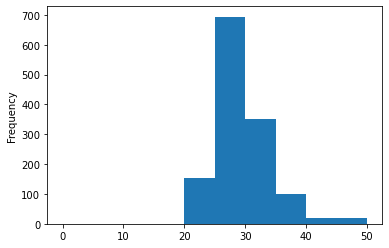

In [8]:
import pandas as pd
df = pd.read_csv('total.csv')
df["Pay per hour"].plot(kind = 'hist')
print(df["Pay per hour"].mean())

2887.979222139111


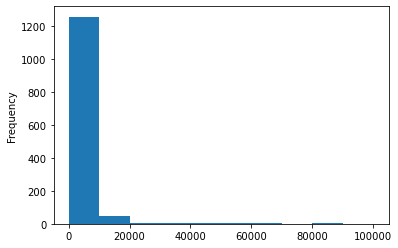

In [9]:
df["Pay total"].plot(kind = 'hist')
print(df["Pay total"].mean())

In [53]:
d = {}
for i in df["Industry"]:
    if i not in d.keys():
        d[i] = 1
    else:
        d[i] += 1
print(d)
d.pop(np.nan)

{'Gastronomie / Hotel': 725, 'Promotion / Event': 234, 'Detailhandel / Logistik': 223, 'Luftverkehr': 7, 'Gesundheitswesen': 98, nan: 21, 'Kaufmännische Berufe': 25, 'Handwerk': 4}


21

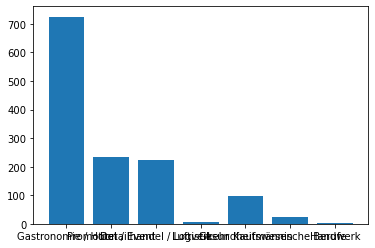

In [54]:
import numpy as np
import matplotlib.pyplot as plt
names = list(d.keys())
values = list(d.values())

plt.bar(range(len(d)), values, tick_label=names)
plt.show()

In [55]:
industry_cat = d.keys()
industry_cat

dict_keys(['Gastronomie / Hotel', 'Promotion / Event', 'Detailhandel / Logistik', 'Luftverkehr', 'Gesundheitswesen', 'Kaufmännische Berufe', 'Handwerk'])

In [56]:
def plot_hist_industry(industry,salary):
    l = []
    for index, row in df.iterrows():
        if row['Industry'] == industry:
            l.append(row[salary])
    plt.hist(l, bins=10, edgecolor='black')
    plt.xlabel(salary)
    plt.ylabel('Frequency')
    plt.show()
    return sum(l)/len(l)

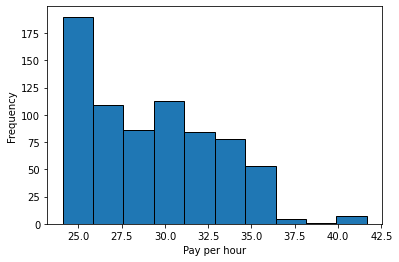

28.99548965517241

In [64]:
hotel = plot_hist_industry('Gastronomie / Hotel','Pay per hour')
hotel

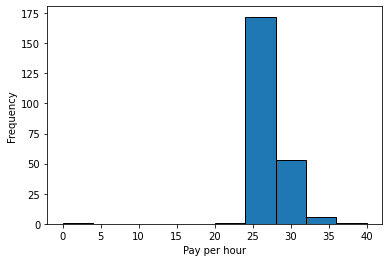

26.702435897435898

In [65]:
promotion = plot_hist_industry('Promotion / Event','Pay per hour')
promotion

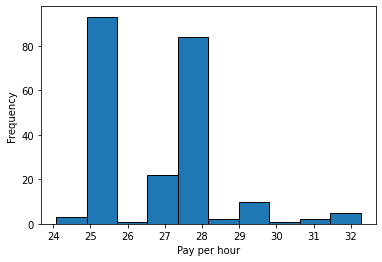

26.810852017937254

In [66]:
logistik = plot_hist_industry('Detailhandel / Logistik','Pay per hour')
logistik

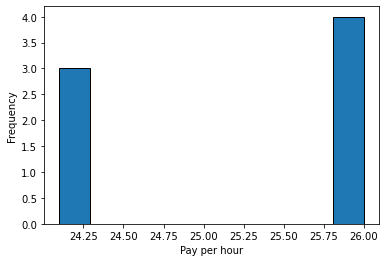

25.185714285714283

In [67]:
luftverkehr = plot_hist_industry('Luftverkehr','Pay per hour')
luftverkehr

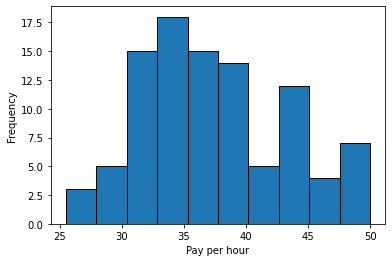

37.59081632653062

In [68]:
Gesundheitswesen = plot_hist_industry('Gesundheitswesen','Pay per hour')
Gesundheitswesen

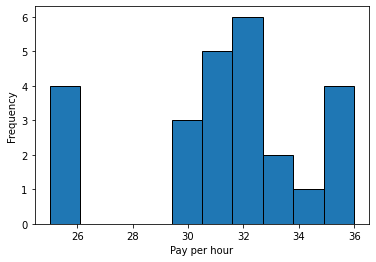

31.211599999999997

In [69]:
berufe = plot_hist_industry('Kaufmännische Berufe','Pay per hour')
berufe

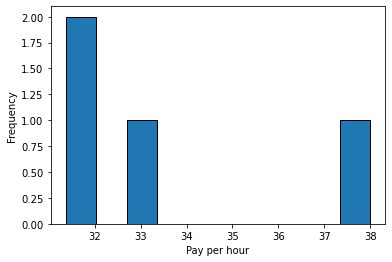

33.435

In [70]:
handwerk = plot_hist_industry('Handwerk','Pay per hour')
handwerk